If you go to the webpage for any TV series on IMDb, you'll see it has a star rating 1-10.  Beneath that, you'll see the show's "Episode Guide", where each episode has a rating of its own.  If you were to take a show's average episode rating and compare it to the show's rating on its primary webpage, they're unlikely to match.  The primary webpage rating is the result of people leaving a single rating for a show in its entirety. 

This primary webpage rating system seems overly constrained to me, so I'd like to compare shows by the collection of their individual episode ratings.  I think this might give us a better idea of how shows actually stack up. 

To avoid opening the floodgates to any and every show (no matter how small its audience), I'll look at shows that have at least one episode with 5000 ratings.  Getting this data into our environment will require webscraping.  

In [2]:
#To get the data we need, we'll need to web scrape with BeautifulSoup. 

import requests
from bs4 import BeautifulSoup as bs

#Below I'm bringing in libraries we'll need to organize/analyze the data

import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sb

#I'll also be installing and importing the pandasql package needed to query a Pandas Dataframe with SQL

In [ ]:
pip install pandasql


In [ ]:
import pandasql as ps


In [ ]:
#Now to start web scraping.

#IMDb's list of episodes with at least 5000 ratings is found at https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=5000,&sort=user_rating,desc 
#I'd like to grab every unique TV series that exists in that list.

#At the time I'm writing this, the list is comprised of 1309 episodes, with distinct webpages for each set of 50 episodes.  
#The URL for each webpage includes 'start=1','start=51','start=101', etc.
#A range iterating between 1 and 1302 will grab each necessary start value, found in the 'page_code' list below.

page_code = list(range(1,1302,50))

#The 'page_link' object will provide a list of each URL with each 'start=' value from the 'page_code' list inserted.

page_link = ['https://www.imdb.com/search/title/?title_type=tv_episode&num_votes=5000,&sort=user_rating,desc&start=' + str(x) + '&ref_=adv_nxt' for x in page_code]

#'soup_objects' will then grab the HTML from each URL, and 'series_tags' will grab a portion of the HTML that houses the unique codes associated with each TV series.
#(These unique codes are what's placed at the end of 'imdb.com/title/' to access a TV series' primary webpage.)

soup_objects = [bs(requests.get(i).content) for i in page_link]
series_tags = [i.find_all(attrs = {'class': 'lister-item-header'}) for i in soup_objects]


In [ ]:
#Our 'series_tags' object is currently a lists of lists. To avoid nested for loops where possible, I'm providing a function that will unpack nested lists into a single list.

def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

unpacked_series_tags = flatten(series_tags)

#'series_codes' iterates through the HTML elements in 'unpacked_series_tags', grabbing each series code, and only keeping a single iteration of each unique code.
#'series_page' then appends each unique code to a URL, creating a list of the URLs associated with each TV series.
#The first five elements of that list can be seen below.

series_codes = list(set([i.find('a')['href'][7:-1] for i in unpacked_series_tags]))
series_page = ['https://www.imdb.com/title/' + str(i) for i in series_codes]

series_page[0:5]

['https://www.imdb.com/title/tt0303461',
 'https://www.imdb.com/title/tt2560140',
 'https://www.imdb.com/title/tt0096697',
 'https://www.imdb.com/title/tt5180504',
 'https://www.imdb.com/title/tt5348176']

In [ ]:
#Because each TV series has a distinct webpage for each of its seasons (which each house the episode data we'd like to extract), my next goal is to identify how many seasons each TV show has.
#Finding this number will indicate how many URLS need to be scraped for each show, as each season URL ends with 'season=1','season=2','season=3', etc.

#The for loop below will iterate through the HTML for each URL in 'series_page', grabbing the number associated with a show's latest season and appending that value to our 'season_num' list. 

season_num = []

for i in series_page:
  temp_site = bs(requests.get(i).content)
  season_num.append(temp_site.find(attrs = {'class': 'seasons-and-year-nav'}).find('a').text)

#'temp_df' creates a dataframe with each TV series' URL and its number of seasons.
#The first five records of that dataframe can be seen below.

temp_df = pd.DataFrame(zip(series_page, season_num), 
               columns =['Series_Page', 'Season_Num']) 

temp_df.head()

,Series_Page,Season_Num
0,https://www.imdb.com/title/tt0303461,1
1,https://www.imdb.com/title/tt2560140,4
2,https://www.imdb.com/title/tt0096697,34
3,https://www.imdb.com/title/tt5180504,2
4,https://www.imdb.com/title/tt5348176,4


In [ ]:
#The next goal is to iterate through each record, creating the URLs associated with each season page for each TV series and appending them to 'season_list'.  
#For example, if record 1 has a 'Season_Num' value of 3, we'd like 3 URLS, each ending in 'season=1','season=2', and 'season=3' respectively.
#The for loop below accomplishes that task. (Because a record's value in Season_Num necessarily functions as a range, a complexity of O(n^2) might be the best we can do here.)
#The first five records of 'season_list' can be seen below.  

season_list = []

for i,v in temp_df.iterrows(): 
   for x in range(1, int(v['Season_Num']) + 1):
     season_list.append(v['Series_Page'] + '/episodes?season=' + str(x))

season_list[0:5]


['https://www.imdb.com/title/tt0303461/episodes?season=1',
 'https://www.imdb.com/title/tt2560140/episodes?season=1',
 'https://www.imdb.com/title/tt2560140/episodes?season=2',
 'https://www.imdb.com/title/tt2560140/episodes?season=3',
 'https://www.imdb.com/title/tt2560140/episodes?season=4']

In [ ]:
#Now we have every URL needed to grab the data associated with every episode for every TV series that has at least one episode with 5000 ratings.
#Because we need to iterate through each URL and scrape its HTML (which also involves iterative processes), this is going to be a demanding task for the computer.

#The data points we need from each URL include: each episode title, its rating, its season/episode number, and the series name.

#This 'temp_dict' dictionary will be where we add/store the data grabbed from each iteration of the for loop.  

temp_dict = {}

for i in season_list:
  
  temp = bs(requests.get(i).content)

  #Using certain HTML indicators, this first 'if' statement is used to check if the season webpage is for a season that hasn't been released yet.  If this is the case, the URL is skipped.

  if '#' in temp.find('a', attrs = {'itemprop':'name'}).text and 'Know what this is about?' in temp.find('div', attrs = {'itemprop':'description'}).text:
    continue

  #The list comprehensions seen below are grabbing the episode titles, episode ratings, season/episode numbers, and the series name for each URL.  

  episode_title = [i.text for i in temp.find_all('a', attrs = {'itemprop':'name'})]
  episode_rating = [i.text for i in temp.find_all('span', attrs = {'class':'ipl-rating-star__rating'}) if '.' in i.text]
  episode_number = [i.text.strip() for i in temp.find_all('div', attrs = {'class':'hover-over-image zero-z-index '})]
  series_name = [temp.h3.a.text for i in episode_title] 
  temp_list = [episode_title, episode_rating, episode_number, series_name]

  #Some active TV seasons have episodes that haven't released yet, but certain HTML indicators for the unreleased episode still exist.
  #For example, episode titles might exist that have no rating.
  #To account for this, the 'min' object below functions as a large, arbitrary value to be tested against the length of our episode_title, episode_rating, episode_number, and series_name lists.
  #The process below finds the minimum value among the lengths of each list and then trims each list to equal that length, which elminates any unreleased episodes.

  min = 10000
  for i in temp_list:
    if len(i) < min:
      min = len(i)
  
  episode_title = episode_title[:min]
  episode_rating = episode_rating[:min]
  episode_number = episode_number[:min]
  series_name = series_name[:min]

  #Now we just need to add each list to our 'temp_dict' dictionary.
  
  if temp_dict == {}:
    temp_dict = {'Episode_Title': episode_title, 'Episode_Rating': episode_rating,
             'Episode_Number': episode_number, 'Series_Name': series_name}
  else:
    temp_dict['Episode_Title'] += episode_title
    temp_dict['Episode_Rating'] += episode_rating
    temp_dict['Episode_Number'] += episode_number
    temp_dict['Series_Name'] += series_name


In [ ]:
#'temp_dict' can now be converted to a dataframe.  The dataframe's first five records can be seen below.

working_df = pd.DataFrame(temp_dict) 

working_df.head()

,Episode_Title,Episode_Rating,Episode_Number,Series_Name
0,The Train Job,8.5,"S1, Ep1",Firefly
1,Bushwhacked,8.5,"S1, Ep2",Firefly
2,Our Mrs. Reynolds,9.0,"S1, Ep3",Firefly
3,Jaynestown,8.7,"S1, Ep4",Firefly
4,Out of Gas,9.4,"S1, Ep5",Firefly


In [ ]:
#IMDb has incomplete/sporadic data for the three shows below, so I just removed them.

disney_index = working_df[working_df['Series_Name'] == 'The Wonderful World of Disney'].index
american_index = working_df[working_df['Series_Name'] == 'American Masters'].index
screen_index = working_df[working_df['Series_Name'] == 'Screen Two'].index

working_df.drop(disney_index, inplace=True)
working_df.drop(american_index, inplace=True)
working_df.drop(screen_index, inplace=True)

In [ ]:
#If we want to look at shows by season, the 'Episode_Number' column (formatted as 'S1, Ep1') will need to be split into two separate columns.  
#The code below splits the values in Episode Number on the commas, and appends the separated season component to a season list.
#The new column is added to the dataframe as 'Season_Number', and 'Episode_Number' is dropped, replaced with a column named 'Season_Episode'
episodes = working_df['Episode_Number']
season_number = []

for i in episodes:
  test = i.split(',')
  season_number.append(test[0].strip())

working_df['Season_Episode'] = working_df['Episode_Number']
working_df['Season_Number'] = season_number
working_df.drop('Episode_Number', axis = 1, inplace = True)


column_names = ['Episode_Title','Season_Episode','Season_Number','Episode_Rating','Series_Name']
working_df = working_df.reindex(columns = column_names)

working_df.head()

,Episode_Title,Season_Episode,Season_Number,Episode_Rating,Series_Name
0,The Train Job,"S1, Ep1",S1,8.5,Firefly
1,Bushwhacked,"S1, Ep2",S1,8.5,Firefly
2,Our Mrs. Reynolds,"S1, Ep3",S1,9.0,Firefly
3,Jaynestown,"S1, Ep4",S1,8.7,Firefly
4,Out of Gas,"S1, Ep5",S1,9.4,Firefly


In [ ]:
#Preparing for aggregation, the 'Episode_Rating' values also need to be converted from string objects to floats.

working_df['Episode_Rating'] = working_df['Episode_Rating'].astype(float)

print(working_df.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8772 entries, 0 to 9086
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Episode_Title   8772 non-null   object 
 1   Season_Episode  8772 non-null   object 
 2   Season_Number   8772 non-null   object 
 3   Episode_Rating  8772 non-null   float64
 4   Series_Name     8772 non-null   object 
dtypes: float64(1), object(4)
memory usage: 411.2+ KB
None


In [ ]:
#It'd be helpful to distinguish between longer shows and newer shows/mini-series, so I'll split the data into two dataframes.
#One will include shows with 3+ seasons, the other with 1-2 seasons.

s3 = working_df.loc[working_df['Season_Number'] == 'S3']
s3_titles = list(set(s3['Series_Name']))
s2 = working_df.loc[working_df['Series_Name'].isin(s3_titles) == False]
s2_titles = list(set(s2['Series_Name']))
long_series = working_df.loc[working_df['Series_Name'].isin(s3_titles)]
short_series = working_df.loc[working_df['Series_Name'].isin(s2_titles)]

#To confirm that every record is accounted for, you can see that the length of the original dataframe equals the length of our two new dataframes combined.

print('All Shows Length: '+  str(len(working_df)))
print('(Long Series + Short Series) Length: '+  str(len(long_series) + len(short_series)))

All Shows Length: 8772
(Long Series + Short Series) Length: 8772


In [ ]:
#Now we're ready to start looking at how our shows stack up
#Below you can see the highest and lowest performing shows with 3+ seasons, as well as the highest and lowest performing seasons among the same group.

from IPython.display import display

long_comp = long_series.groupby(['Series_Name'])
display(long_comp['Episode_Rating'].agg(['mean','min','max']).round(2).sort_values(by = 'mean', ascending= False))

long_test = long_series.groupby(['Series_Name','Season_Number'])
display(long_test['Episode_Rating'].agg(['mean','min','max']).round(2).sort_values(by = 'mean', ascending= False))


,mean,min,max
Series_Name,,,
Attack on Titan,9.24,8.4,10.0
Dark,9.07,8.2,9.7
Person of Interest,9.03,8.2,9.9
Mr. Robot,9.02,8.1,9.9
Breaking Bad,9.02,7.8,10.0
...,...,...,...
13 Reasons Why,7.24,5.2,9.2
The Simpsons,7.18,3.9,9.3
Family Guy,7.17,3.8,9.1


mean  min   max
Series_Name     Season_Number                 
Attack on Titan S3             9.45  8.8  10.0
Breaking Bad    S5             9.43  8.9  10.0
Attack on Titan S4             9.42  8.7  10.0
Mr. Robot       S4             9.35  8.4   9.9
True Detective  S1             9.32  8.9   9.7
...                             ...  ...   ...
The Simpsons    S32            6.24  5.5   6.9
                S30            6.08  4.5   7.0
Doctor Who      S11            6.02  4.9   8.1
                S12            5.99  4.0   7.4
House of Cards  S6             3.92  2.5   4.4

[506 rows x 3 columns]

In [ ]:
#Here you can see the same thing performed among shows with 1-2 seasons, this time using SQL to do our grouping/aggregations.

pd.set_option('display.max_rows', 10)

display(ps.sqldf(
    'SELECT Series_Name, ROUND(AVG(Episode_Rating),2) mean, MIN(Episode_Rating) min, MAX(Episode_Rating) max FROM short_series GROUP BY Series_Name ORDER BY 2 DESC',
     globals()))

display(ps.sqldf(
    'SELECT Series_Name, Season_Number, ROUND(AVG(Episode_Rating),2) mean FROM short_series GROUP BY Series_Name, Season_Number ORDER BY 3 DESC',
    globals()))

,Series_Name,mean,min,max
0,Chernobyl,9.62,9.5,9.9
1,Band of Brothers,9.08,8.7,9.5
2,When They See Us,9.05,8.5,9.6
3,Sense8,8.80,7.6,9.5
4,Firefly,8.76,8.3,9.4
...,...,...,...,...
29,Altered Carbon,7.54,6.4,8.6
30,"Love, Death & Robots",7.41,6.3,8.6
31,Dracula,6.97,5.2,8.1
32,Knight Rider,6.82,6.0,7.3


,Series_Name,Season_Number,mean
0,Chernobyl,S1,9.62
1,Band of Brothers,S1,9.08
2,When They See Us,S1,9.05
3,Sense8,S2,9.01
4,The Mandalorian,S2,8.94
...,...,...,...
42,Knight Rider,S1,6.82
43,Hello Ladies,S2,6.70
44,Altered Carbon,S2,6.60
45,Masters of Horror,S1,6.28


[(7.4, 10.1), Text(0, 0.5, 'Episode Rating'), [], Text(0.5, 0, 'Episode / Season'), Text(0.5, 1.0, 'Attack on Titan Ratings (w/ 10.0s labeled)')]


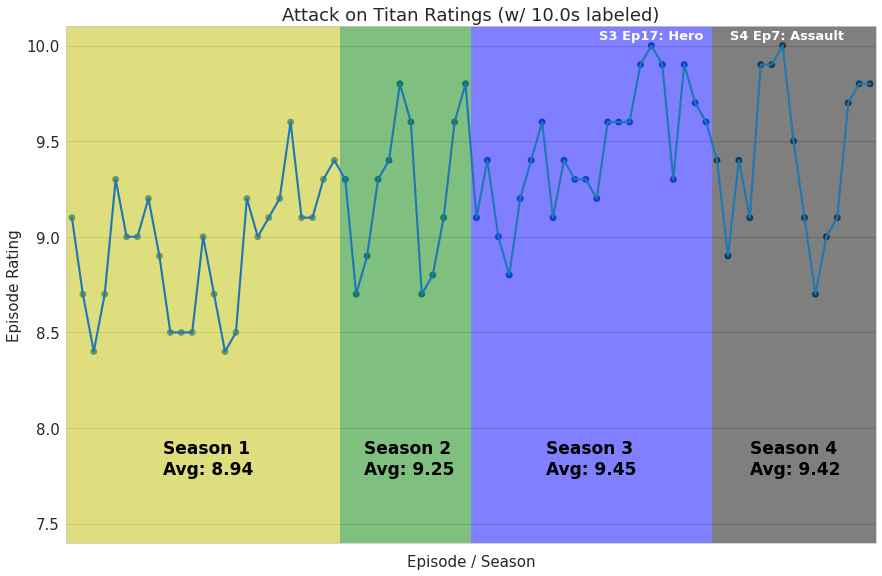

In [ ]:
#Looking at TV series with 3+ seasons, I want to take a closer look at some of the highest performing shows, visualizing how they performed from beginning to end.
#We'll look at some of the top 5 shows, Attack on Titan, Dark, and Breaking Bad, as well as Game of thrones which performed quite well for a while before jumping off a cliff at the end.
#First, the highest performing show, Attack on Titan.

titan = long_series.loc[long_series['Series_Name'] == 'Attack on Titan']
titan_test = titan.groupby(['Series_Name','Season_Number'])
titan_df = titan_test['Episode_Rating'].agg(['mean']).round(2).sort_values(by = 'Season_Number')

sb.set_style("whitegrid")
plt.figure(figsize = (14.5,9.5))

plt.rcParams.update({'font.size': 15,'font.weight':'normal'})
plt.text(48.2,10.035,'S3 Ep17: Hero', fontdict = {'size': 13, 'weight':'bold','color':'w'})
plt.text(60.2,10.035,'S4 Ep7: Assault', fontdict = {'size': 13, 'weight':'bold','color':'w'})
plt.text(8.3,7.76,'Season 1 \n' + 'Avg: ' + str(titan_df.iloc[0]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(26.68,7.76,'Season 2 \n' + 'Avg: ' + str(titan_df.iloc[1]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(43.35,7.76,'Season 3 \n' + 'Avg: ' + str(titan_df.iloc[2]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(62.05,7.76,'Season 4 \n' + 'Avg: ' + str(titan_df.iloc[3]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.axvspan(-1, 24.5, color='y', alpha=0.5, lw=0)
plt.axvspan(24.5, 36.5, color='g', alpha=0.5, lw=0)
plt.axvspan(36.5, 58.5, color='b', alpha=0.5, lw=0)
plt.axvspan(58.5, 74, color='k', alpha=0.5, lw=0)
g = sb.pointplot(data = titan, x = titan['Season_Episode'], y = titan['Episode_Rating'], scale = .78)
print(g.set(title = 'Attack on Titan Ratings (w/ 10.0s labeled)', xlabel = 'Episode / Season', ylabel = 'Episode Rating', xticklabels = [], ylim=(7.4,10.1)))

#Among episodes with at least 5000 ratings, IMDb only has three episodes rated a 10/10, two of which are from Attack on Titan (labeled in our visualization)
#Attack on Titan's seasons 3 and 4 are also the highest performing seasons among all shows with at least one episode with 5000 ratings.

[(7.4, 10.1), Text(0, 0.5, 'Episode Rating'), [], Text(0.5, 0, 'Episode / Season'), Text(0.5, 1.0, 'Dark Ratings')]


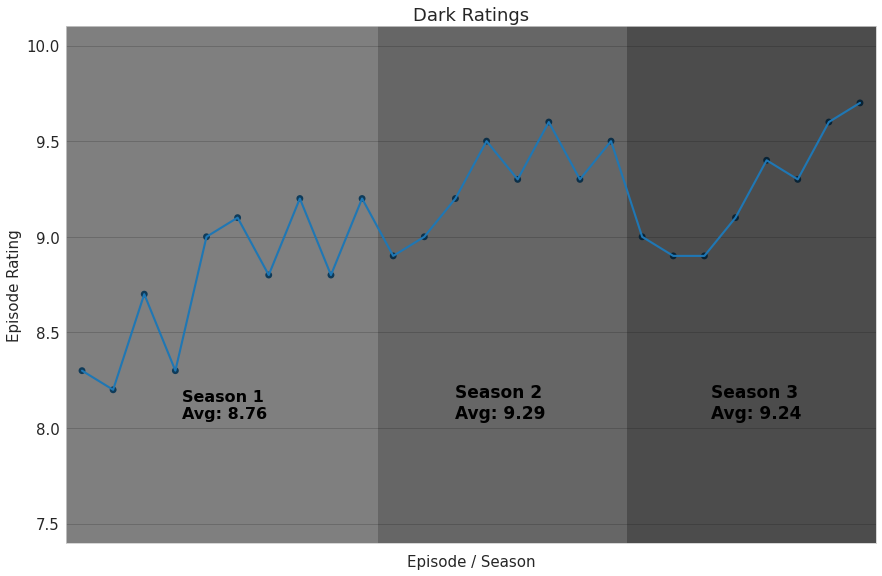

In [ ]:
#Next, the 2nd highest performing show, Dark.

dark = long_series.loc[long_series['Series_Name'] == 'Dark']
dark_test = dark.groupby(['Series_Name','Season_Number'])
dark_df = dark_test['Episode_Rating'].agg(['mean']).round(2).sort_values(by = 'Season_Number')

plt.figure(figsize = (14.5,9.5))

plt.rcParams.update({'font.size': 15,'font.weight':'normal'})
plt.text(3.2,8.05,'Season 1 \n' + 'Avg: ' + str(dark_df.iloc[0]['mean']), fontdict = {'size': 16, 'weight':'bold','color':'k'})
plt.text(12,8.05,'Season 2 \n' + 'Avg: ' + str(dark_df.iloc[1]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(20.2,8.05,'Season 3 \n' + 'Avg: ' + str(dark_df.iloc[2]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.axvspan(-1, 9.5, color='k', alpha=.5, lw=0)
plt.axvspan(9.5, 17.5, color='k', alpha=0.6, lw=0)
plt.axvspan(17.5, 25.5, color='k', alpha=0.7, lw=0)


g = sb.pointplot(data = dark, x = dark['Season_Episode'], y = dark['Episode_Rating'], scale = .78)
print(g.set(title = 'Dark Ratings', xlabel = 'Episode / Season', ylabel = 'Episode Rating', xticklabels = [], ylim=(7.4,10.1)))

#In our rankings by series as a whole, Dark is our second highest performing show, just behind Attack on Titan

[(7.4, 10.1), Text(0, 0.5, 'Episode Rating'), [], Text(0.5, 0, 'Episode / Season'), Text(0.5, 1.0, 'Breaking Bad Ratings (w/ 10.0s labeled)')]


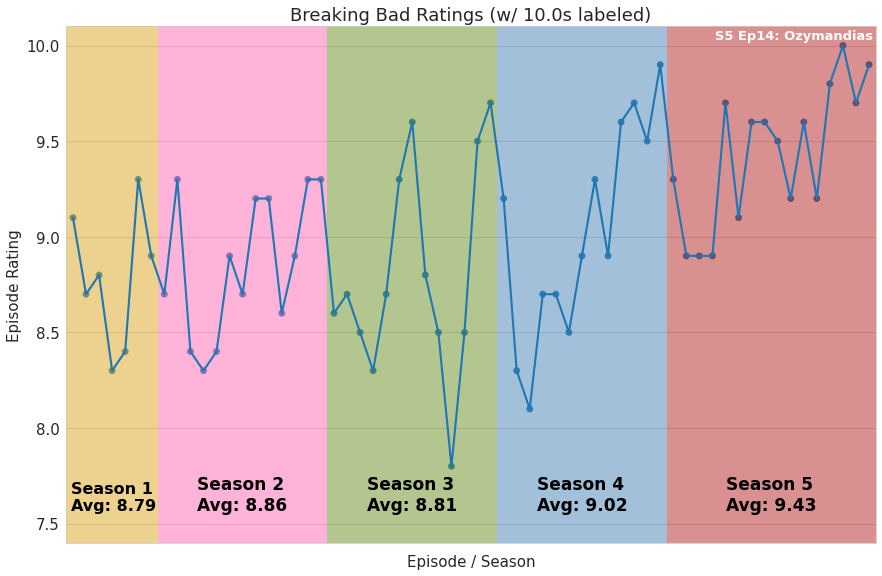

In [ ]:
#Third, let's look at Breaking Bad.

bad = long_series.loc[long_series['Series_Name'] == 'Breaking Bad']
bad_test = bad.groupby(['Series_Name','Season_Number'])
bad_df = bad_test['Episode_Rating'].agg(['mean']).round(2).sort_values(by = 'Season_Number')

plt.figure(figsize = (14.5,9.5))

plt.rcParams.update({'font.size': 15,'font.weight':'normal'})
plt.text(-.17,7.57,'Season 1 \n' + 'Avg: ' + str(bad_df.iloc[0]['mean']), fontdict = {'size': 16, 'weight':'bold','color':'k'})
plt.text(9.53,7.57,'Season 2 \n' + 'Avg: ' + str(bad_df.iloc[1]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(22.53,7.57,'Season 3 \n' + 'Avg: ' + str(bad_df.iloc[2]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(35.53,7.57,'Season 4 \n' + 'Avg: ' + str(bad_df.iloc[3]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(50.05,7.57,'Season 5 \n' + 'Avg: ' + str(bad_df.iloc[4]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(49.2,10.035,'S5 Ep14: Ozymandias', fontdict = {'size': 13, 'weight':'bold','color':'w'})

plt.axvspan(-1, 6.5, color='goldenrod', alpha=0.5, lw=0)
plt.axvspan(6.5, 19.5, color='hotpink', alpha=0.5, lw=0)
plt.axvspan(19.5, 32.5, color='olivedrab', alpha=0.5, lw=0)
plt.axvspan(32.5, 45.5, color='steelblue', alpha=0.5, lw=0)
plt.axvspan(45.5, 61.5, color='firebrick', alpha=0.5, lw=0)

g = sb.pointplot(data = bad, x = bad['Season_Episode'], y = bad['Episode_Rating'], scale = .78)
print(g.set(title = 'Breaking Bad Ratings (w/ 10.0s labeled)', xlabel = 'Episode / Season', ylabel = 'Episode Rating', xticklabels = [], ylim=(7.4,10.1)))

#Breaking Bad is a top 5 show but is likely the most well-known among our top 5.  It also has one of IMDb's three episodes ranked a 10/10, S5 Ep 14: Ozymandias.

[(3.0, 10.1), Text(0, 0.5, 'Episode Rating'), [], Text(0.5, 0, 'Episode / Season'), Text(0.5, 1.0, 'Game of Thrones Ratings')]


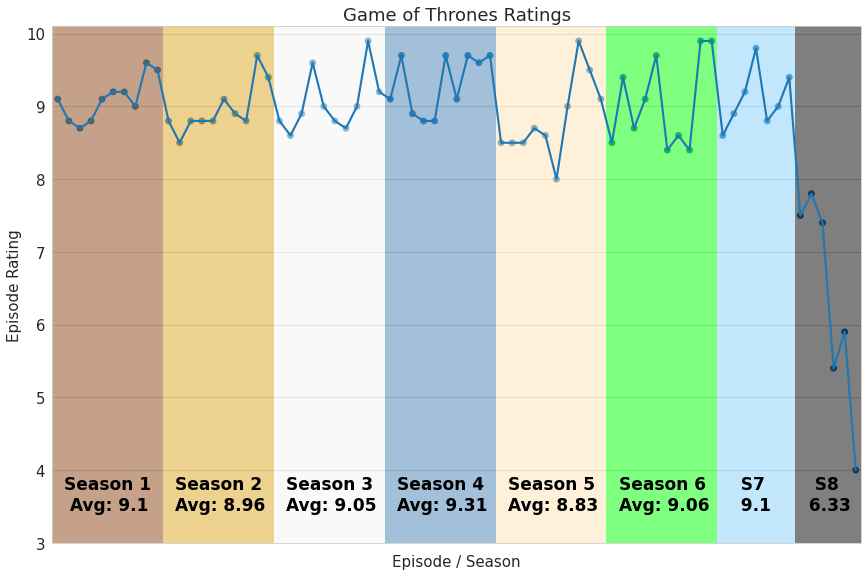

In [ ]:
#And the last show we'll take a closer look at, Game of Thrones.

game = long_series.loc[long_series['Series_Name'] == 'Game of Thrones']
game_test = game.groupby(['Series_Name','Season_Number'])
game_df = game_test['Episode_Rating'].agg(['mean']).round(2).sort_values(by = 'Season_Number')

plt.figure(figsize = (14.5,9.5))

plt.rcParams.update({'font.size': 15,'font.weight':'normal'})
plt.text(.6,3.45,'Season 1 \n' + ' Avg: ' + str(game_df.iloc[0]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(10.6,3.45,'Season 2 \n' + 'Avg: ' + str(game_df.iloc[1]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(20.6,3.45,'Season 3 \n' + 'Avg: ' + str(game_df.iloc[2]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(30.6,3.45,'Season 4 \n' + 'Avg: ' + str(game_df.iloc[3]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(40.6,3.45,'Season 5 \n' + 'Avg: ' + str(game_df.iloc[4]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(50.6,3.45,'Season 6 \n' + 'Avg: ' + str(game_df.iloc[5]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(60.6,3.45,'  S7 \n' + '  ' + str(game_df.iloc[6]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.text(67.23,3.45,'  S8 \n' + ' ' + str(game_df.iloc[7]['mean']), fontdict = {'size': 17, 'weight':'bold','color':'k'})
plt.axvspan(-1, 9.5, color='saddlebrown', alpha=0.5, lw=0)
plt.axvspan(9.5, 19.5, color='goldenrod', alpha=0.5, lw=0)
plt.axvspan(19.5, 29.5, color='whitesmoke', alpha=0.5, lw=0)
plt.axvspan(29.5, 39.5, color='steelblue', alpha=0.5, lw=0)
plt.axvspan(39.5, 49.5, color='moccasin', alpha=0.5, lw=0)
plt.axvspan(49.5, 59.5, color='lime', alpha=0.5, lw=0)
plt.axvspan(59.5, 66.5, color='lightskyblue', alpha=0.5, lw=0)
plt.axvspan(66.5, 72.5, color='k', alpha=0.5, lw=0)
g = sb.pointplot(data = game, x = game['Season_Episode'], y = game['Episode_Rating'], scale = .78)
print(g.set(title = 'Game of Thrones Ratings', xlabel = 'Episode / Season', ylabel = 'Episode Rating', xticklabels = [], ylim=(3,10.1)))

#Game of Thrones is likely one of the most popular shows ever.  It performed quite well for most of its tenure, but then jumped off a cliff at the end.
#Its final episode is the 7th worst rated episode among over 8000 episodes from shows with 3+ seasons

[(7.75, 8.5), Text(0, 0.5, 'Average Rating'), [Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3'), Text(0, 0, '4'), Text(0, 0, '5'), Text(0, 0, '6'), Text(0, 0, '7'), Text(0, 0, '8'), Text(0, 0, '9'), Text(0, 0, '10')], Text(0.5, 0, 'Season Number'), Text(0.5, 1.0, 'Average Rating by Season (All Shows)')]


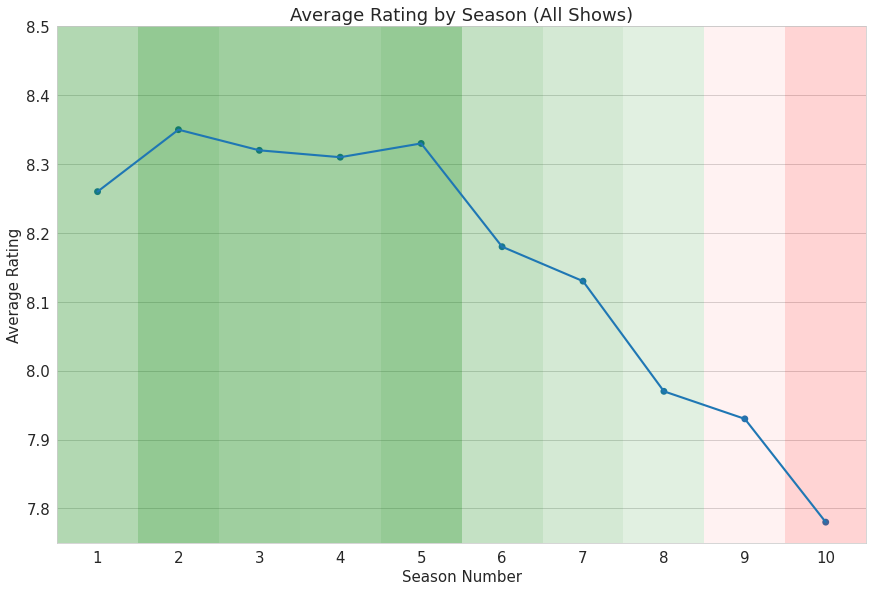

In [ ]:
#The last exercise I'd like to do is observe how all shows typically perform season over season.

#'testing' and 'season_df' will create a dataframe that includes each aggregated season number, along with its average episode rating.

testing = long_series.groupby(['Season_Number'])
season_df = testing['Episode_Rating'].agg(['mean']).round(2).sort_values(by = 'Season_Number').reset_index()

#In 'Season_Num', we're separating slicing 'Season_Number', keeping only the number component of the string and converting them to integers.
#The original 'Season_Number' column is then dropped, and the new dataframe is reordered, reindexed, and sorted by season number in ascending order (seasons 1 - 10).

season_df['Season_Num'] = [int(v['Season_Number'][1:]) for i,v in season_df.iterrows()]

season_df.drop('Season_Number', axis = 1, inplace = True)

column_names = ['Season_Num','mean']
season_df = season_df.reindex(columns = column_names)

season_df = season_df.sort_values('Season_Num').reset_index(drop = True)[0:10]

#Now we can visualize the data and see what we find

sb.set_style("whitegrid")
plt.figure(figsize = (14.5,9.5))

plt.axvspan(-.5, .5, color='green', alpha=51.5, lw=0)
plt.axvspan(.5, 1.5, color='green', alpha=20.5, lw=0)
plt.axvspan(1.5, 2.5, color='green', alpha=32.5, lw=0)
plt.axvspan(2.5, 3.5, color='green', alpha=34.5, lw=0)
plt.axvspan(3.5, 4.5, color='green', alpha=22.5, lw=0)
plt.axvspan(4.5, 5.5, color='green', alpha=69.5, lw=0)
plt.axvspan(5.5, 6.5, color='green', alpha=85.5, lw=0)
plt.axvspan(6.5, 7.5, color='green', alpha=98.5, lw=0)
plt.axvspan(7.5, 8.5, color='red', alpha=115.5, lw=0)
plt.axvspan(8.5, 9.5, color='red', alpha=85.5, lw=0)


g = sb.pointplot(data = season_df, x = season_df['Season_Num'], y = season_df['mean'], scale = .78)
print(g.set(title = 'Average Rating by Season (All Shows)', xlabel = 'Season Number', ylabel = 'Average Rating', xticklabels = [1,2,3,4,5,6,7,8,9,10], ylim=(7.75,8.5)))

#Looks like, for the most part, show performance has a sweet spot between 2-5 seasons, generally declining each season beyond 5.  

In [ ]:
long_series.to_csv('long_series.csv', index = False)
short_series.to_csv('short_series.csv', index = False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
long_series = pd.read_csv('/content/drive/MyDrive/TV Project/long_series.csv')
short_series = pd.read_csv('/content/drive/MyDrive/TV Project/short_series.csv')
